# Ex 9

In [1]:
# Import von python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

cm = 1/2.54

## Aufg. 1: Non-linear fit by trying out parameters

First, we create data which roughly follows an exponential decay function by adding random numbers picked from a normal distribution to the exponential decay function. We will use the exact same process as for the linear fit in exercise 8. 

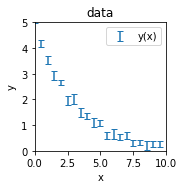

In [2]:
# create data
def exp_decay(t, decay_time, amplitude):
    return amplitude * np.exp(-t/decay_time)
np.random.seed(1) # so we always get the same random data
t = np.linspace(0,10,20, endpoint=False) # x values
decay_time = 3
amplitude = 5
y = exp_decay(t, decay_time, amplitude) + np.random.normal(loc=0, scale=0.1, size=len(t))  
sig = 0.1 + np.random.random(len(t))*0.1 # sigma values
fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('data')
ax.set_xlim([0,10])
ax.set_ylim([0,5])
ax.legend(loc='upper right')
plt.show()

Now we compute the sum of the residuals (the sum of squared deviations between fit function and data) for a range of guesses for decay_time and amplitude and plot it in a 2D logscale plot with decay_time and amplitude on the axes. 
Compute the sum of residuals and put it into the correct shape. 

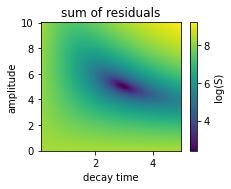

In [3]:
# plot sum of residuals for different a0 and a1
# create arrays of values for a1 and a0 to try out
dt_try = np.linspace(0.1,5,201)
amp_try = np.linspace(0,10,301)
w = 1/sig**2
# ============== write here
S = np.zeros((len(amp_try), len(dt_try)))
for i, amp_i in enumerate(amp_try):
    for j, dt_j in enumerate(dt_try):
        S[i,j] = np.sum(1/sig**2 * (y - exp_decay(t, dt_j, amp_i))**2)
# or
S = np.sum(w * (y[np.newaxis, :] - exp_decay(t[np.newaxis, :], dt_try[:, np.newaxis], amp_try[:,np.newaxis,np.newaxis]) )**2, axis=-1 )
# ==============

# now plot log(S)
fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
# plot log(S)
c = ax.pcolormesh(dt_try, amp_try, np.log(S), shading='nearest')


# cosmetics
fig.colorbar(c, ax=ax, label='log(S)')
ax.set_xlabel('decay time')
ax.set_ylabel('amplitude')
ax.set_title('sum of residuals')
plt.show()

Now we find the minimum of S and determine the corresponding values of decay time and amplitude. Use numpy's integrated functionality to do this. 

In [4]:
# ============== write here
# by looking for the index with the minimum value of S, we can find the optimum for a0 and a1
min_index_S = np.argmin(S) # this function returns the index of the flattened S array with the minimum value of S
# now we recover the correct a0 and a1 fit values
dt_index = min_index_S % len(dt_try)
amp_index = min_index_S // len(dt_try)
dt_fit = dt_try[dt_index]
amp_fit = amp_try[amp_index]
# ==============
print(f'decay time = {dt_fit:.1f}') # should be 3.0
print(f'amplitude = {amp_fit:.1f}') # should be 5.0

decay time = 3.0
amplitude = 5.0


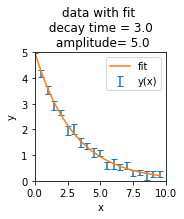

In [5]:
# finally, we plot the data with the acquired fit values 
fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
ax.plot(t, exp_decay(t, dt_fit, amp_fit), label='fit')
ax.set_title('data with fit \n decay time = %.1f \n amplitude= %.1f' % (dt_fit, amp_fit))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0,10])
ax.set_ylim([0,5])
ax.legend(loc='upper right')
plt.show()

## Aufg. 2: Non-linear fit using gradient descent

In this exercise we optimize the blind parameter search from Aufg. 1 using gradient descent. The idea is that instead of searching the whole parameter space, we only search along the direction of decreasing $S$. That should eventually bring us close to the minimum. 

First we need a function to calculate the sum of residuals S. So far we have written this out explicitly, but for any function f(x) with data y(x) and weights w(x), we want a function 
Sres(x, y, w, func, a)
which returns the sum of the residuals. 


In [6]:
# ============= Sres
def Sres(x, y, w, func, a):
    return np.sum(w*(y-func(x, a))**2)
# =============

Next, we need to calculate the gradient of S with respect to all the parameters of f(x), which we will name a[0], a[1], ...
This function returns the vector dS, with dS[i]=dS/da[i]. 
Comment on every line and explain what that line is doing. 

In [7]:
def dS(S, x, y, w, model, a, delta):    
    # Numerical calculation of the first derivatice of S
    
    # add a comment to every line that explains what that line does. 

    # Number of fit parameters
    m = len(a)
    
    # Return vector 
    delta_S = np.zeros(m)
    
    # Iterate over all parameters
    for i in range(0,m):
        # Differential vector for only the differentiation parameter (partial differentiation)
        delta_a = np.zeros(m)
        delta_a[i] = delta
        
        # Differential vector at the position a
        delta_a_plus = a + delta_a
        delta_a_minus = a - delta_a
        
        # Calculate partial differential for i-th parameter 
        delta_S[i] = (S(x, y, w, model, delta_a_plus)-S(x, y, w, model, delta_a_minus))/(2*delta)
    return delta_S

Later, we will also need the second derivative of S, so here is a function that does this. Again, add comments to every line explaining the calculation done in that line. 

In [8]:
def dS2(S, x, y, w, model, a, delta):
    # Numerical calculation of the decond derivatice of S
    
    # Number of fit parameters
    m = len(a)
    
    # Return vector 
    delta_S = np.zeros((m,m))
    
    # Iterate over all parameters
    for i in range(0,m):
        for j in range(0,m):
            # Differential vector for only the differentiation parameter (partial differentiation)
            delta_ai = np.zeros(m)
            delta_aj = np.zeros(m)
            delta_ai[i] = delta
            delta_aj[j] = delta
                       
            # Differential vector at the position a
            delta_a_plusplus = a + delta_ai + delta_aj
            delta_a_plusminus = a + delta_ai - delta_aj
            delta_a_minusplus = a - delta_ai + delta_aj
            delta_a_minusminus = a - delta_ai - delta_aj           
            
            # Calculate partial differential for i-th parameter 
            delta_S[i,j] = (S(x, y, w, model, delta_a_plusplus)-S(x, y, w, model, delta_a_minusplus)-S(x, y, w, model, delta_a_plusminus)+S(x, y, w, model, delta_a_minusminus))/(2*delta)**2
    return delta_S

Now, we repeatedly move our initial guess a_init for the parameters a in the direction of a lower sum of residuals S or, in other words, towards the minimum of the gradient of S. Add the calculation of the covariance matrix to the following function: 

In [9]:
def gradient_descent_simple(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    # Gradient descent fitting
    
    
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    # Magnitude of the gradient
    d_a = [np.linalg.norm(gradient)]
    
    

    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i]>min_gradient) and (i<max_i)):
        
        # Calculate next step using the gradient 
        a_next = a_next - alpha * gradient
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        
        # Termination condition
        d_a = np.append(d_a, np.linalg.norm(gradient))
    
        # Next Step
        i = i+1
    # =========== compute covariance matrix
    hesse = dS2(S, x, y, w, model, a_next, delta)
    cov_matrix = 2*np.linalg.inv(hesse)
    # ===========
    return a_next, i, d_a, cov_matrix

Before we can use our gradient descent function, we need to define a model function for the exponential decay and decide on the meta-parameters min_gradient, max_i, alpha and delta, as well as guess some initial parameters. 
Explain what exactly each meta parameters does. 

In [10]:
def exp_decay_model(x, a):
    return a[1]*np.exp(-x/a[0])

In [11]:
# ============ explain here what the meta parameters do. 
model = exp_decay_model # this selects the function we fit to
min_gradient = 0.001 # min_gradient is the convergence criterion. When the gradient gets under this value, the loop stops and the current parameters are returned
max_i = 10000 # this is the maximum number of iterations. Without convergence the loop will stop at 10000 iterations and return the current parameters as fit. 
alpha = 1e-5 # this parameter determins how fast we adapt the parameters in the search. In each step we change the guess for our fit parameters by alpha x gradient. 
delta = 1e-3 # this is the range over which we determine the gradient (the slope) of S with respect to a parameter a. We compute (S(a + delta) - S(a - delta))/(2*delta) to approximate the partial derivative of S with respect to a.  
a_init = np.array([1,1]) # these are our initial guesses for the parameters

In [12]:
a_fit, iterations, d_a, cov_matrix = gradient_descent_simple(Sres, t, y, w, model, a_init, min_gradient, max_i, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit: ', a_fit)
print('Iterations: ', iterations)
print('final da: ', d_a[-1])
print('============')
print('Covariance Matrix: ')
print(cov_matrix)

Fit Results:
Best fit:  [2.97218741 5.03233843]
Iterations:  10000
final da:  0.0013908959241300245
Covariance Matrix: 
[[ 0.00885723 -0.0067379 ]
 [-0.0067379   0.0115612 ]]


Play around with the meta parameters to get a fast convergence. 

Now, we plot the data with the fit. Add the errors of the parameters to the title of the plot as done in ex8. 

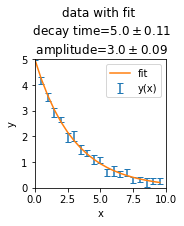

In [13]:
# finally, we plot the data with the acquired fit values 
fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
ax.plot(t, exp_decay(t, *a_fit), label='fit')
# add the errors of the fit parameters to the title of the plot
dt_error = np.sqrt(cov_matrix[0,0])
amp_error = np.sqrt(cov_matrix[1,1])
# ax.set_title('data with fit \n decay time = %.1f \n amplitude= %.1f' % (a_fit[1], a_fit[0])) # <--
ax.set_title('data with fit \n decay time=$%.1f \pm %.2f$ \n amplitude=$%.1f \pm %.2f$' % (a_fit[1], amp_error, a_fit[0], dt_error ))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0,10])
ax.set_ylim([0,5])
ax.legend(loc='upper right')
plt.show()

This looks as expected. Play around with the initial parameters and the meta-parameters to adapt the convergence. Additionally, plot the convergence d_a in a semilog-plot over the iterations. Explain your observations. Compare the convergence to that using a different cost function log(S) and explain the behavior. For the comparison it is useful to draw several plots in the same window, so you can see the difference. 

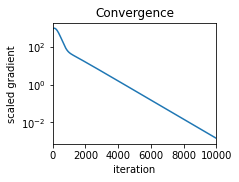

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
# ============= plot the cost function
ax.semilogy(np.arange(iterations+1), d_a, label='simple grad desc')
# =============
ax.set_title('Convergence')
ax.set_ylabel('scaled gradient')
ax.set_xlabel('iteration')
ax.set_xlim([0,max_i])
fig.tight_layout(pad=0.1)
plt.show()

## Aufg. 3: Gradient descent with adaptive step size

Now, we want to adapt the scale parameter alpha with every step for better convergence. In the copy of gradient_descent_simple below, add that functionality. In particular, we want to have the option to scale alpha with the inverse curvature of S. 

In [15]:
def gradient_descent_adaptive(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    # Gradient descent fitting
    
    
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and Hesse matrix for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    hesse = dS2(S, x, y, w, model, a_next, delta)
    hdiag = np.diagonal(hesse)
    # Magnitude of the gradient
    d_a = [np.linalg.norm(gradient)]

    
    

    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i]>min_gradient) and (i<max_i)):
        
        # Calculate next step using the gradient 
        # ============= scale alpha with the inverse of the second derivative
        a_next = a_next - alpha * 1/(hdiag+0.0001) * gradient
        # =============
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        hesse = dS2(S, x, y, w, model, a_next, delta)
        hdiag = np.diagonal(hesse)
        
        # Termination condition
        d_a = np.append(d_a, np.linalg.norm(gradient))
    
        # Next Step
        i = i+1
    # =========== compute covariance matrix
    cov_matrix = 2*np.linalg.inv(hesse)
    # ===========
    return a_next, i, d_a, cov_matrix

adapt the meta parameters if necessary

In [16]:
model = exp_decay_model
min_gradient = 0.001
max_i = 10000
alpha = 1e-2
delta = 1e-3
a_init = np.array([1,1])

Now, we repeat the calculation

In [17]:
a_adaptive, iterations_adaptive, d_a_adaptive, cov_matrix_adaptive = gradient_descent_adaptive(Sres, t, y, w, model, a_init, min_gradient, max_i, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit: ', a_adaptive)
print('Iterations: ', iterations_adaptive)
print('final da: ', d_a_adaptive[-1])
print('============')
print('Covariance Matrix: ')
print(cov_matrix_adaptive)

Fit Results:
Best fit:  [2.97218543 5.03234128]
Iterations:  3024
final da:  0.0009999061714982829
Covariance Matrix: 
[[ 0.00885722 -0.0067379 ]
 [-0.0067379   0.0115612 ]]


Finally, plot in one semilogy-plot both the convergences from the simple and the adaptive gradient descent. Compare the results and comment on the difference. 

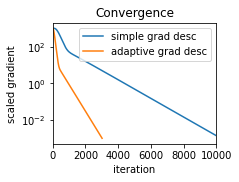

In [18]:
# =============
fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
ax.semilogy(np.arange(iterations+1), d_a, label='simple grad desc')
ax.semilogy(np.arange(iterations_adaptive+1), d_a_adaptive, label='adaptive grad desc')
ax.set_title('Convergence')
ax.set_ylabel('scaled gradient')
ax.set_xlabel('iteration')
ax.set_xlim([0,max_i])
ax.legend(loc='upper right')
fig.tight_layout(pad=0.1)
plt.show()
# =============

## Bonus Aufg.: Normal distribution

Create a dataset that follows a normal distribution with std=5 and x0=0, add noise on top of it and fit the appropriate function to recover the distribution of the data. Copy and modify or use the functions from above. 

define the model

In [19]:
# =============
def gaussian_model(x, a):
    x0 = a[0]
    std = a[1]
    return np.exp(-1/2 * ((x-x0)/std)**2)
# =============

create the data

In [20]:
x = np.linspace(-20,20,200, endpoint=False) # x values
x0 = 0
std = 5
# =============
y = gaussian_model(x, [x0, std]) + np.random.normal(loc=0, scale=0.1, size=len(x))  
sig = 0.1 + np.random.random(len(x))*0.1 # sigma values
w = 1/sig**2
# =============

fit the data using gradient descent. first define the meta parameters

In [21]:
# =============
model = gaussian_model
min_gradient = 0.0001
max_i = 20000
alpha = 0.001
delta = 0.0001
a_init = np.array([1,1])
# =============

then execute the fit

In [22]:
# =============
a_adaptive, iterations_adaptive, d_a_adaptive, cov_matrix_adaptive = gradient_descent_adaptive(Sres, x, y, w, model, a_init, min_gradient, max_i, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit: ', a_adaptive)
print('Iterations: ', iterations_adaptive)
print('final da: ', d_a_adaptive[-1])
print('============')
print('Covariance Matrix: ')
print(cov_matrix_adaptive)
# =============

Fit Results:
Best fit:  [ 0.01075106 -5.11237329]
Iterations:  15772
final da:  9.997984294241707e-05
Covariance Matrix: 
[[0.0218839  0.00047427]
 [0.00047427 0.01584427]]


plot the convergence

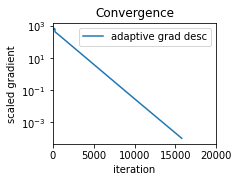

In [23]:
# =============
fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
ax.semilogy(np.arange(iterations_adaptive+1), d_a_adaptive, label='adaptive grad desc')
ax.set_title('Convergence')
ax.set_ylabel('scaled gradient')
ax.set_xlabel('iteration')
ax.set_xlim([0,max_i])
ax.legend(loc='upper right')
fig.tight_layout(pad=0.1)
plt.show()
# =============

plot the fit

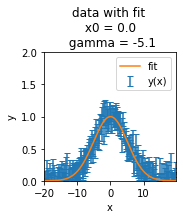

In [24]:
# =============
fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
ax.plot(x, gaussian_model(x, a_adaptive), label='fit')
ax.set_title('data with fit \n x0 = %.1f \n gamma = %.1f' % (a_adaptive[0], a_adaptive[1]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([0,2])
ax.legend(loc='upper right')
plt.show()
# =============

## lmfit Example

Of course, we don't go through all the trouble of writing these functions every time we want to fit something. The python package lmfit offers this funcitonality. Here is an example adapted from https://stackoverflow.com/questions/44573896/python-fit-gaussian-to-noisy-data-with-lmfit which you can use in your future fitting efforts.  

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 200
    # variables        = 3
    chi-square         = 100.747344
    reduced chi-square = 0.51140784
    Akaike info crit   = -131.140306
    Bayesian info crit = -121.245354
[[Variables]]
    amplitude:  12.8690455 +/- 0.23795427 (1.85%) (init = -0.5)
    center:    -0.07153667 +/- 0.11103267 (155.21%) (init = 0.290625)
    sigma:      5.24169404 +/- 0.11394197 (2.17%) (init = 7.2)
    fwhm:       12.3432460 +/- 0.26831282 (2.17%) == '2.3548200*sigma'
    height:     0.97945561 +/- 0.01851425 (1.89%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.569


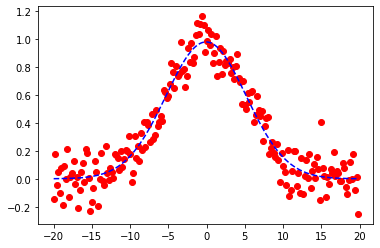

In [25]:
import numpy as np
from lmfit import Model
from lmfit.models import GaussianModel, ConstantModel
import matplotlib.pyplot as plt

x = np.linspace(-20,20,200, endpoint=False) # x values
x0 = 0
std = 5
y = gaussian_model(x, [x0, std]) + np.random.normal(loc=0, scale=0.1, size=len(x))  
sig = 0.1 + np.random.random(len(x))*0.1 # sigma values
w = 1/sig**2

model = GaussianModel()

pars = model.guess(y, x=x, amplitude=-0.5)

result = model.fit(y, pars, x=x, weights=1/sig)
print(result.fit_report())

plt.plot(x, y, 'ro', ms=6)
plt.plot(x, result.best_fit, 'b--')